# ***Importing Necessary Dependancies :***

---



In [1]:
# Built-in Modules
import os
import re
import zipfile
import warnings

# Data Science and Machine Learning Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Processing Libraries
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC

import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


# Configuration
# ============================
# Ignore warnings
warnings.filterwarnings("ignore")

# Set maximum column width for pandas DataFrame display
pd.set_option('display.max_colwidth', None)

# Set seaborn theme for visualizations
sns.set_theme()

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# NLTK Data Downloads
nltk.download('punkt')
nltk.download('stopwords')

# Install Required Libraries
!pip install scikit-learn


2025-11-20 17:02:32.793164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 17:02:32.830996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 17:02:33.994932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/nhatanh/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarn

# ***Loading Dataset :***

---



In [2]:
data = pd.read_csv('./dataset.csv')


In [3]:
data.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})


,is_rumor
count,62443.000000
mean,0.221386
std,0.415183
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [4]:
data.head()


,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBCDanielS: Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago”",0.0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is being considered terrorism right now or lone wolf?,0.0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention that before knowing the facts #islamphobiaatitsbest,0.0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0.0,freethought41,charliehebdo


In [5]:
data['num_words'] = data['text'].apply(lambda x: len(x.split()))
avg_words = round(data['num_words'].mean())
max_words = round(data['num_words'].max())
print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))

print("--------------------")
data['is_rumor'].value_counts()


Average length: 14
Max length: 34
--------------------


is_rumor
0.0    48619
1.0    13824
Name: count, dtype: int64

# **Data shape:**

---



In [6]:
print(f'The number of columns: = {data.shape[1]}\nThe number of rows: = {data.shape[0]}')

# Check dublicates:
print("dublicated Data: ", data.duplicated().sum())


The number of columns: = 5
The number of rows: = 62445
dublicated Data:  800


In [7]:
# Drop dublicates
df = data.drop_duplicates()


# Check dublicates:
df.duplicated().sum()


np.int64(0)

In [8]:
# Drop blanks columns:

# Identify the rows with blank values
blanks = df.isnull().any(axis=1)

# Drop the rows with blank values
df.drop(df[blanks].index, inplace=True)

# Final Shape:
print(f'The number of columns: = {df.shape[1]}\nThe number of rows: = {df.shape[0]}')


The number of columns: = 5
The number of rows: = 48871


In [9]:
df['is_rumor'].value_counts()


is_rumor
0.0    42590
1.0     6281
Name: count, dtype: int64

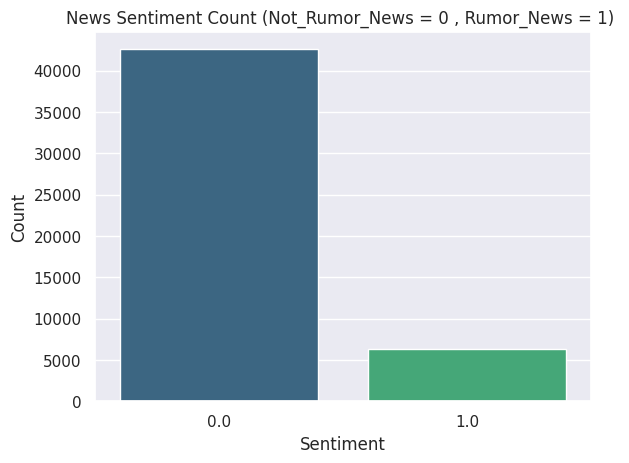

In [10]:
# Assume (Rumor_News = 1 ,  Not_Rumor_News = 0)
sns.countplot(data=df, x='is_rumor', palette='viridis')
plt.title('News Sentiment Count (Not_Rumor_News = 0 , Rumor_News = 1) ')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


Text(0.5, 1.0, 'Percentage of Our is_rumor in dataset')

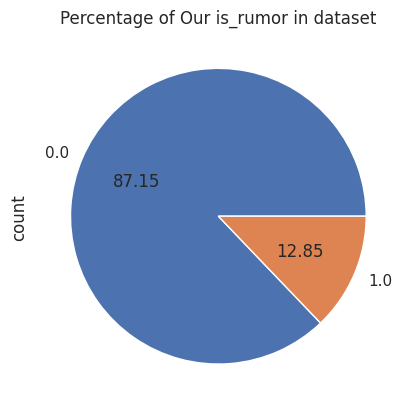

In [11]:
df['is_rumor'].value_counts().plot.pie(autopct='%.2f')
plt.title('Percentage of Our is_rumor in dataset')


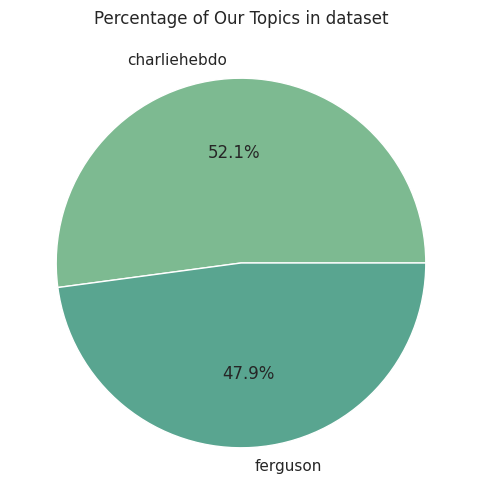

In [12]:
sns.set_palette("crest")
sns.set_style("whitegrid")

plt.figure(figsize=(6, 6))
df['topic'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Our Topics in dataset')
plt.ylabel(None)
plt.show()


# **Needed only columns is:**


---


*   Test.
*   Target.

In [13]:
# df = df[['text', 'target']]
# df.head()


# **Text Preprocessing**

---
*   Convert text to lowercase and remove unnecessary characters
*   Tokenization
*   Removing special characters
*   Removing stop words and punctuation
*   Stemming







In [14]:
# Convert text to lowercase and remove unnecessary characters
data.loc[:, 'text'] = data['text'].str.lower().str.replace('[^\w\s]', '', regex=True)
data['text']


0                                                              charlie hebdo became well known for publishing the muhammed cartoons two years ago
1          now 10 dead in a shooting there today rt bbcdaniels charlie hebdo became well known for publishing the muhammed cartoons two years ago
2                                                       bbcdaniels bbcworld im guessing this is being considered terrorism right now or lone wolf
3                                                    bbcdaniels bbcworld why would you mention that before knowing the facts islamphobiaatitsbest
4                                                                                                            bbcdaniels bbcworld perps identified
                                                                           ...                                                                   
62440                                                                    anonyops xplant so that means its ok to torch and l

In [15]:
# Remove Punctuation
def remove_pun(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['text'] = df['text'].apply(remove_pun)

df.head()


,text,is_rumor,user.handle,topic,num_words
0,Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo,13
1,Now 10 dead in a shooting there today RT BBCDanielS Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago”,0.0,robbylevy,charliehebdo,23
2,BBCDanielS BBCWorld Im guessing this is being considered terrorism right now or lone wolf,0.0,ModerateInAll,charliehebdo,14
3,BBCDanielS BBCWorld why would you mention that before knowing the facts islamphobiaatitsbest,0.0,GabTarquini,charliehebdo,12
4,BBCDanielS BBCWorld perps identified,0.0,freethought41,charliehebdo,4


In [16]:
pip install nltk --index-url https://pypi.tuna.tsinghua.edu.cn/simple


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
# remove stopwords
def remove_stopwords(text):
    # Download the stopwords corpus if it hasn't been downloaded already
    nltk.download('stopwords', quiet=True)

    # Get the list of stopwords
    stop_words = set(stopwords.words('english'))

    # Split the text into words
    words = text.split()

    # Remove the stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Join the filtered words back into a single string
    filtered_text = ' '.join(filtered_words)

    return filtered_text

df['text'] = df['text'].apply(remove_stopwords)

df.head()


,text,is_rumor,user.handle,topic,num_words
0,Charlie Hebdo became well known publishing Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo,13
1,10 dead shooting today RT BBCDanielS Charlie Hebdo became well known publishing Muhammed cartoons two years ago”,0.0,robbylevy,charliehebdo,23
2,BBCDanielS BBCWorld Im guessing considered terrorism right lone wolf,0.0,ModerateInAll,charliehebdo,14
3,BBCDanielS BBCWorld would mention knowing facts islamphobiaatitsbest,0.0,GabTarquini,charliehebdo,12
4,BBCDanielS BBCWorld perps identified,0.0,freethought41,charliehebdo,4


In [18]:
nltk.download('punkt_tab', quiet=True) # Add this line to download the missing resource

# Tokenization
def data_processing(text):
    # Remove mentions and hashtags
    text = re.sub(r'\@w+|\#', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    text_tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if w.lower() not in stop_words]

    return " ".join(filtered_text)

df['text'] = df['text'].apply(data_processing)

df.head()


,text,is_rumor,user.handle,topic,num_words
0,Charlie Hebdo became well known publishing Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo,13
1,10 dead shooting today RT BBCDanielS Charlie Hebdo became well known publishing Muhammed cartoons two years ago,0.0,robbylevy,charliehebdo,23
2,BBCDanielS BBCWorld Im guessing considered terrorism right lone wolf,0.0,ModerateInAll,charliehebdo,14
3,BBCDanielS BBCWorld would mention knowing facts islamphobiaatitsbest,0.0,GabTarquini,charliehebdo,12
4,BBCDanielS BBCWorld perps identified,0.0,freethought41,charliehebdo,4


In [19]:
# Stemmer
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df['text'] = df['text'].apply(stemming)

df.head()


,text,is_rumor,user.handle,topic,num_words
0,Charlie Hebdo became well known publishing Muhammed cartoons two years ago,0.0,BBCDanielS,charliehebdo,13
1,10 dead shooting today RT BBCDanielS Charlie Hebdo became well known publishing Muhammed cartoons two years ago,0.0,robbylevy,charliehebdo,23
2,BBCDanielS BBCWorld Im guessing considered terrorism right lone wolf,0.0,ModerateInAll,charliehebdo,14
3,BBCDanielS BBCWorld would mention knowing facts islamphobiaatitsbest,0.0,GabTarquini,charliehebdo,12
4,BBCDanielS BBCWorld perps identified,0.0,freethought41,charliehebdo,4


In [20]:
# # Ensure 'is_rumor' is integer type
# data.loc['is_rumor'] = data['is_rumor'].astype(int)
# data['is_rumor']

# Ensure 'is_rumor' is integer type
# Fill missing values with a suitable integer (e.g., -1 to represent unknown)
df['is_rumor'] = df['is_rumor'].fillna(-1).astype(int)

# Display the 'is_rumor' column to verify the changes
df['is_rumor']


0        0
1        0
2        0
3        0
4        0
        ..
62440    1
62441    1
62442    1
62443    1
62444    1
Name: is_rumor, Length: 48871, dtype: int64

In [21]:
# Apply on 'text' column contains the text data in train_df
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Display the DataFrame with the new 'num_words' column
print(df[['text', 'num_words']])

print('------------------------------------------------------------------------------')

avg_words = round(df['num_words'].mean())
max_words = round(df['num_words'].max())

print('Average length: {}'.format(avg_words))
print('Max length: {}'.format(max_words))


                                                                                                                       text  \
0                                                Charlie Hebdo became well known publishing Muhammed cartoons two years ago   
1           10 dead shooting today RT BBCDanielS Charlie Hebdo became well known publishing Muhammed cartoons two years ago   
2                                                      BBCDanielS BBCWorld Im guessing considered terrorism right lone wolf   
3                                                      BBCDanielS BBCWorld would mention knowing facts islamphobiaatitsbest   
4                                                                                      BBCDanielS BBCWorld perps identified   
...                                                                                                                     ...   
62440                                                                 AnonyOps Xplant means ok torch loot someo

<Axes: xlabel='num_words', ylabel='Count'>

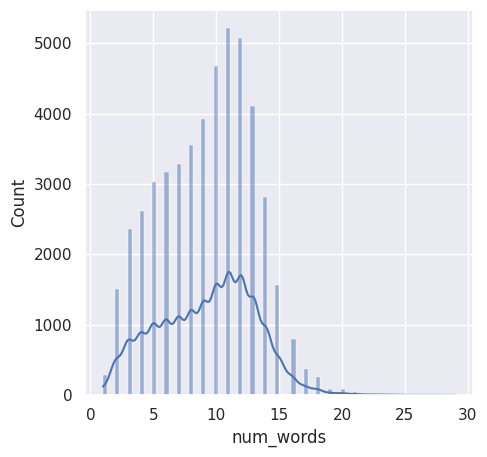

In [22]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.histplot(df['num_words'], kde=True)


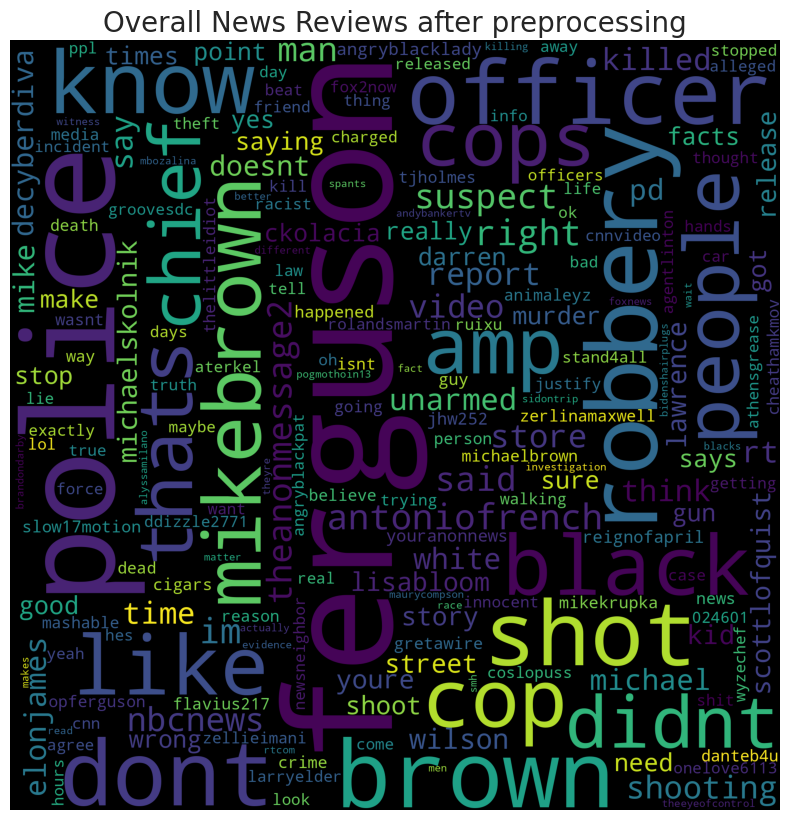

In [23]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df[df['is_rumor'] == 1]['text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Overall News Reviews after preprocessing", fontsize = 20)
plt.show()


# **Model Building**

---


# Initialize DeBERTa-v3 Model and Tokenizer for Sequence Classification

In [25]:
# Initialize the tokenizer and model
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


I0000 00:00:1763633077.958501   13957 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at mi

# Tokenize the datasets

In [27]:
# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Function to tokenize the data
def tokenize_data(data, tokenizer, max_length):
    return tokenizer(
        list(data['text']),  # Assuming the text column is named 'text'
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

# Tokenize the train and test datasets
max_length = 64
train_encodings = tokenize_data(train_df, tokenizer, max_length)
test_encodings = tokenize_data(test_df, tokenizer, max_length)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


# Create TensorFlow datasets

In [28]:
# Create TensorFlow datasets
def create_tf_dataset(encodings, labels):
    labels = tf.convert_to_tensor(labels.values)
    dataset = tf.data.Dataset.from_tensor_slices((
        {key: encodings[key] for key in encodings if key in ['input_ids', 'attention_mask']},
        labels
    ))
    return dataset

batch_size = 16
train_dataset = create_tf_dataset(train_encodings, train_df['is_rumor']).batch(batch_size)
test_dataset = create_tf_dataset(test_encodings, test_df['is_rumor']).batch(batch_size)


# Train the model

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=batch_size,
    epochs=15
)



Epoch 1/15
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2025-11-20 17:05:08.485447: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f2ac4022a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-20 17:05:08.485470: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-11-20 17:05:08.491603: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 17:05:08.514252: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
I0000 00:00:1763633108.606448   14581 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2444/2444 [==============================] - 680s 264ms/step - loss: 0.2428 - accuracy: 0.9043 - val_loss: 0.1707 - val_accuracy: 0.9303
Epoch 2/15
2444/2444 [==============================] - 680s 264ms/step - loss: 0.2428 - accuracy: 0.9043 - val_loss: 0.1707 - val_accuracy: 0.9303
Epoch 2/15
2444/2444 [==============================] - 630s 258ms/step - loss: 0.1255 - accuracy: 0.9532 - val_loss: 0.1141 - val_accuracy: 0.9570
Epoch 3/15
2444/2444 [==============================] - 630s 258ms/step - loss: 0.1255 - accuracy: 0.9532 - val_loss: 0.1141 - val_accuracy: 0.9570
Epoch 3/15
2444/2444 [==============================] - 617s 253ms/step - loss: 0.0805 - accuracy: 0.9702 - val_loss: 0.1098 - val_accuracy: 0.9605
Epoch 4/15
2444/2444 [==============================] - 617s 253ms/step - loss: 0.0805 - accuracy: 0.9702 - val_loss: 0.1098 - val_accuracy: 0.9605
Epoch 4/15
2444/2444 [==============================] - 628s 257ms/step - loss: 0.0575 - accuracy: 0.9793 - val_loss: 0.118

PermissionError: [Errno 13] Permission denied: '/content'

In [30]:

# Save the model
model_save_path = "./content/saved_model"
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = "./content/saved_tokenizer"
tokenizer.save_pretrained(tokenizer_save_path)


('./content/saved_tokenizer/tokenizer_config.json',
 './content/saved_tokenizer/special_tokens_map.json',
 './content/saved_tokenizer/spm.model',
 './content/saved_tokenizer/added_tokens.json',
 './content/saved_tokenizer/tokenizer.json')

# Training history

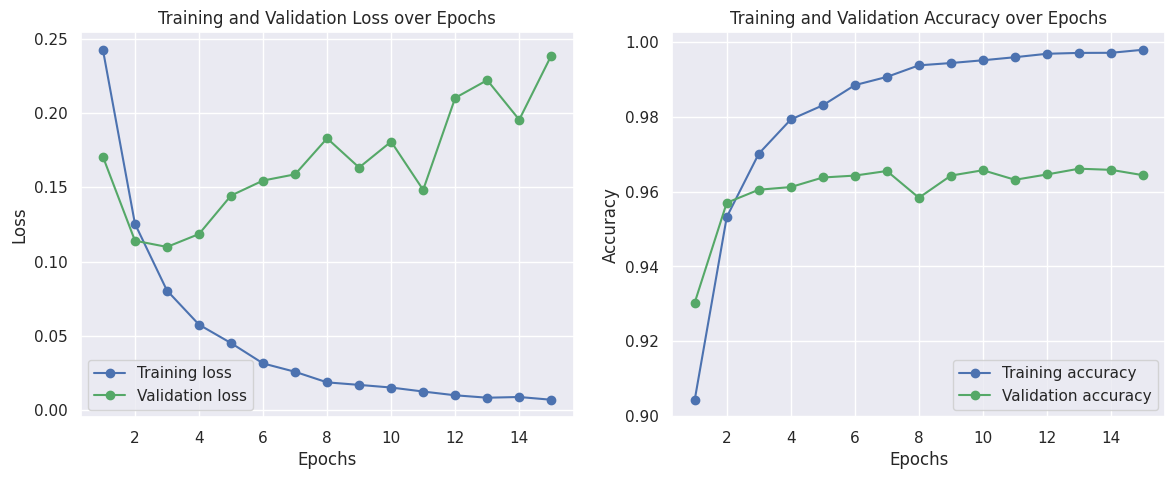

In [31]:
# Extract training metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))  # Create an epoch list

# Plot training loss and validation loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'g-o', label='Validation loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Extract training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-o', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g-o', label='Validation accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Load and Evaluate Pretrained Sequence Classification Model

In [32]:
# Load the model
loaded_model = TFAutoModelForSequenceClassification.from_pretrained(model_save_path)

# Load the tokenizer
loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)

# Compile the model
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

test_loss, test_accuracy = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at ./content/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.
All the layers of TFDebertaV2ForSequenceClassification were initialized from the model checkpoint at ./content/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


611/611 [==============================] - 52s 73ms/step - loss: 0.2388 - accuracy: 0.9644
Test Loss: 0.2388
Test Accuracy: 0.9644
611/611 [==============================] - 52s 73ms/step - loss: 0.2388 - accuracy: 0.9644
Test Loss: 0.2388
Test Accuracy: 0.9644


# Evaluate Model Predictions and Display Metrics

Accuracy: 0.9644
F1 Score: 0.9634
Precision: 0.9635
Recall: 0.9644

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      8497
           1       0.91      0.80      0.86      1278

    accuracy                           0.96      9775
   macro avg       0.94      0.90      0.92      9775
weighted avg       0.96      0.96      0.96      9775



2025-11-20 20:03:56.724547: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


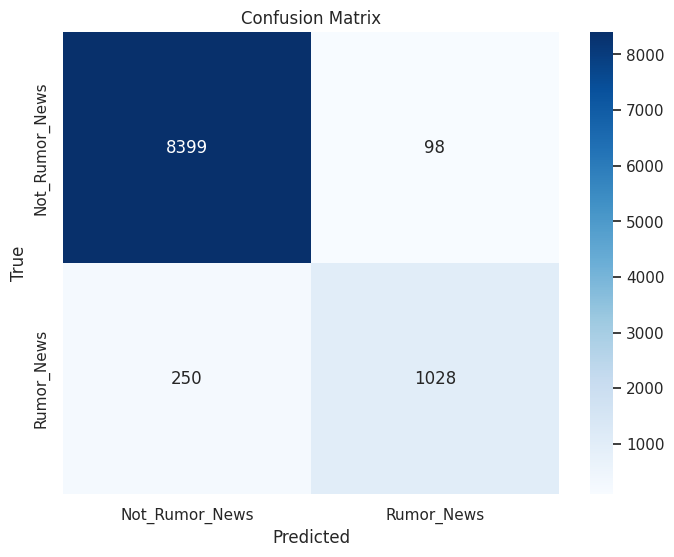

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make predictions on the test dataset
def get_predictions(model, dataset):
    predictions = []
    true_labels = []
    for batch in dataset:
        inputs = {key: val for key, val in batch[0].items()}
        labels = batch[1].numpy()
        logits = model(inputs, training=False).logits  # Ensure you access the logits
        batch_predictions = np.argmax(logits.numpy(), axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(labels)
    return np.array(predictions), np.array(true_labels)

# Get predictions and true labels
predictions, true_labels = get_predictions(loaded_model, test_dataset)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Show classification report
report = classification_report(true_labels, predictions)
print("\nClassification Report:\n", report)

# Mapping dictionary
# Not_Rumor_News = 0 , Rumor_News = 1
label_mapping = {'Not_Rumor_News': 0, 'Rumor_News': 1}
labels = list(label_mapping.keys())

# Display confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Zip Trained Model and Tokenizer for Storage

In [34]:
import zipfile
import os


# Zip file name
zip_file_name = "./content/trained_model_and_tokenizer.zip"

# Zip the directories
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model files to the zip
    for root, _, files in os.walk(model_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(model_save_path, '..')))

    # Add tokenizer files to the zip
    for root, _, files in os.walk(tokenizer_save_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(tokenizer_save_path, '..')))

print(f"Model and tokenizer zipped successfully to {zip_file_name}.")


Model and tokenizer zipped successfully to ./content/trained_model_and_tokenizer.zip.
